In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader , Subset, random_split
from torch.utils.tensorboard import SummaryWriter

In [2]:
import sys
import re
import numpy as np
import pandas as pd
import random
from itertools import chain

import matplotlib.pyplot as plt

In [3]:
import import_ipynb
from preprocessor import *

importing Jupyter notebook from preprocessor.ipynb


In [4]:
from collections import defaultdict

In [5]:
from torch.nn.utils.rnn import pad_sequence

In [6]:
from nltk.tokenize import word_tokenize
from konlpy.tag import *

In [7]:
mecab = Mecab()

## Data

In [8]:
dir_path = '../../Data/'
data = pd.read_excel(dir_path + '한국어_대화체_번역.xlsx' , engine='openpyxl')

In [9]:
data_size = len(data)

data[['원문','번역문']].head()

,원문,번역문
0,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...
1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...
2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ..."
3,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o..."
4,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...


## Preprocessing

In [10]:
en_data = data['번역문']
kor_data = data['원문']

In [11]:
en_encoder = Preprocessor(en_data, word_tokenize, th=3)
en_df = pd.read_csv('./Embedding/csv/en_idx2word.csv')
en_encoder.set_dict(en_df)

In [12]:
kor_encoder = Preprocessor(kor_data, mecab.morphs, th=5)
kor_df = pd.read_csv('./Embedding/csv/kor_idx2word.csv')
kor_encoder.set_dict(kor_df)

In [13]:
en_idx_data = en_encoder.encode()
kor_idx_data = kor_encoder.encode()

## Data Analysis

In [14]:
en_len = [len(idx_data) for idx_data in en_idx_data]
kor_len = [len(idx_data) for idx_data in kor_idx_data]

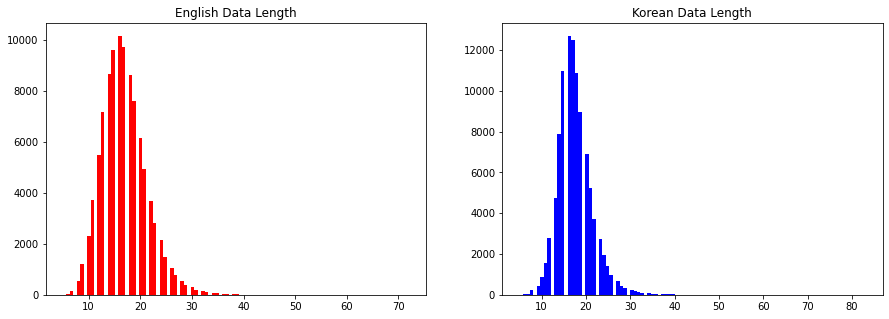

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

axes[0].set_title('English Data Length')
axes[0].hist(en_len, color='r', bins=100)

axes[1].set_title('Korean Data Length')
axes[1].hist(kor_len, color='b', bins=100)

plt.show()

## Data Selecting

In [16]:
min_size = 10
max_size = 25
idx_list = [i for i in range(data_size) \
            if (min(en_len[i],kor_len[i])>=min_size) and (max(en_len[i],kor_len[i])<=max_size)]

In [17]:
en_idx_data = [en_idx_data[i] for i in idx_list]
kor_idx_data = [kor_idx_data[i] for i in idx_list]

## Dataset & DataLoader

In [18]:
class TranslationDataset(Dataset) :

    def __init__(self, en_index, de_index, val_ratio=0.1) :
        super(TranslationDataset , self).__init__()
        self.idx_data = self.build_data(en_index, de_index)
        self.val_ratio = val_ratio
        
    def build_data(self, en_data, de_data) :
        data_len = len(en_data)
        idx_data = [(en_data[i],de_data[i]) for i in range(data_len)]
        
        return idx_data

    def __len__(self) :
        return len(self.idx_data)

    def __getitem__(self , idx) :
        return self.idx_data[idx]
    
    def split(self) :
        n_val = int(len(self) * self.val_ratio)
        n_train = len(self) - n_val
        train_set, val_set = random_split(self, [n_train, n_val])
        
        return train_set, val_set

In [66]:
class Collator:
    def __init__(self, sen_size):
        self.sen_size = sen_size
        
    def __call__(self, batch_samples):
        
        src_tensor = []
        tar_tensor = []
        for src_idx, tar_idx in batch_samples:
            src_tensor.append(torch.tensor(src_idx))
            tar_tensor.append(torch.tensor(tar_idx))
        
        src_tensor = pad_sequence(src_tensor, batch_first=True, padding_value=Token.PAD_IDX.value)
        src_tensor = F.pad(src_tensor,
                           (0,self.sen_size-src_tensor.shape[1]),
                           mode='constant', 
                           value=Token.PAD_IDX.value)
    
        tar_tensor = pad_sequence(tar_tensor, batch_first=True, padding_value=Token.PAD_IDX.value)
        tar_tensor = F.pad(tar_tensor,
                           (0,self.sen_size+1-tar_tensor.shape[1]),
                           mode='constant', 
                           value=Token.PAD_IDX.value)
    
        return {'encoder_in' : src_tensor, 
                'decoder_in' : tar_tensor[:,:-1], 
                'decoder_out' : tar_tensor[:,1:]}

In [67]:
max_len = 25
batch_size = 64

dataset = TranslationDataset(kor_idx_data, en_idx_data)
train_data, val_data = dataset.split()
collator = Collator(max_len)

In [68]:
train_loader = DataLoader(train_data,
                          num_workers=4,
                          shuffle=True,
                          batch_size=batch_size,
                          collate_fn=collator)

val_loader = DataLoader(val_data,
                        num_workers=4,
                        shuffle=False,
                        batch_size=batch_size,
                        collate_fn=collator)

## Device & Seed

In [69]:
use_cuda = torch.cuda.is_available()
random.seed(20210906)
torch.cuda.manual_seed_all(20210906)
device = torch.device("cuda" if use_cuda else "cpu") 

## Model

In [70]:
class PaddingMask(nn.Module) :

    def __init__(self, sen_size) :
        super(PaddingMask , self).__init__() 
        self.sen_size = sen_size
    
    def forward(self, in_tensor) :
        batch_size = in_tensor.shape[0]
        # mask tensor which element is 0.0
        flag_tensor = torch.where(in_tensor == 0.0 , 1.0 , 0.0)
        # shape : (batch_size, 1, 1, sen_size)
        flag_tensor = torch.reshape(flag_tensor , (batch_size, 1, 1, self.sen_size)) 
        
        return flag_tensor

In [71]:
class LookAheadMask(nn.Module) :

    def __init__(self, sen_size, cuda_flag) :
        super(LookAheadMask, self).__init__() 
        self.sen_size = sen_size
        self.mask_tensor = self.get_mask(sen_size).cuda() if cuda_flag else self.get_mask(sen_size)

    def get_mask(self, sen_size) :
        # masking tensor
        mask_array = 1 - np.tril(np.ones((sen_size,sen_size)) , 0)
        mask_tensor = torch.tensor(mask_array , dtype = torch.float32 , requires_grad=False)
        mask_tensor = mask_tensor.unsqueeze(0) # shape : (1, sen_size, sen_size)

        return mask_tensor
    
    def forward(self, in_tensor) :
        lookahead_mask_tensor = torch.maximum(in_tensor, self.mask_tensor)

        return lookahead_mask_tensor

In [72]:
class PositionalEncoding(nn.Module) :

    def __init__(self, pos_len, d_model, cuda_flag) :
        super(PositionalEncoding , self).__init__()
        self.pos_len = pos_len
        self.d_model = d_model

        # w : weight
        # pe : Encoding tensor
        if cuda_flag == True :
            self.w = torch.sqrt(torch.tensor(d_model, dtype=torch.float32, requires_grad=False)).cuda()
            self.pe = self.get_embedding(pos_len, d_model).cuda()

        else :
            self.w = torch.sqrt(torch.tensor(d_model, dtype=torch.float32, requires_grad=False))
            self.pe = self.get_embedding(pos_len, d_model)

    # Embedding tensor : (batch_size, sen_size, embedding_dim)
    # Making Encoding tensor (1, sen_size, embedding_dim)
    def get_embedding(self, pos_len, d_model) :
        pos_vec = torch.arange(pos_len).float()
        pos_vec = pos_vec.unsqueeze(1)

        i_vec = torch.arange(d_model).float() / 2
        i_vec = torch.floor(i_vec) * 2
        i_vec = i_vec.unsqueeze(0) / d_model
        i_vec = 1 / torch.pow(1e+4 , i_vec)

        em = torch.mul(pos_vec, i_vec)
        pe = torch.zeros(pos_len, d_model, requires_grad=False)
        sin_em = torch.sin(em)
        cos_em = torch.cos(em)

        pe[:,::2] = sin_em[:,::2]
        pe[:,1::2] = cos_em[:,1::2]

        return pe.unsqueeze(0)

    def forward(self, in_tensor) :
        en_tensor = (in_tensor * self.w) + self.pe
        
        return en_tensor

In [73]:
class MultiHeadAttention(nn.Module) :

    def __init__(self, sen_size,  d_model, num_heads) :
        super(MultiHeadAttention , self).__init__()
        self.sen_size = sen_size # sen_size
        self.d_model = d_model # embedidng_dim
        self.num_heads = num_heads # head_size
        self.depth = int(d_model / num_heads) # embedding_dim / num_heads

        self.q_layer = nn.Linear(d_model, d_model)
        self.k_layer = nn.Linear(d_model, d_model)
        self.v_layer = nn.Linear(d_model, d_model)
        self.o_layer = nn.Linear(d_model, d_model)

        self.scale = torch.sqrt(torch.tensor(self.depth , dtype=torch.float32 , requires_grad=False))
        
        self.init_param()

    def split(self, tensor) :
        tensor = torch.reshape(tensor, (-1, self.sen_size, self.num_heads, self.depth)) # (batch_size, sen_size, num_heads, depth)
        tensor = tensor.permute(0,2,1,3) # (batch_size, num_heads, sen_size, depth)

        return tensor

    def merge(self, tensor) :
        tensor = tensor.permute(0,2,1,3) # (batch_size, sen_size, num_heads, depth)
        tensor = torch.reshape(tensor, (-1, self.sen_size, self.d_model)) # (batch_size , sen_size , embedding_dim)

        return tensor

    def scaled_dot_production(self, q_tensor, k_tensor, v_tensor, m_tensor) :
        q_tensor = self.split(q_tensor)
        k_tensor = self.split(k_tensor)
        v_tensor = self.split(v_tensor)
        
        k_tensor_T = k_tensor.permute(0,1,3,2) # (batch_size, num_heads, depth, sen_size)

        qk_tensor = torch.matmul(q_tensor , k_tensor_T) # (batch_size, num_heads, sen_size, sen_size)
        qk_tensor /= self.scale

        # pad mask tensor shape : (batch_size, 1, 1, sen_size)
        # lookahead mask tensor shape : (batch_size, 1, sen_size, sen_size)
        if m_tensor != None :
            qk_tensor -= (m_tensor * 1e+6)

        qk_tensor = F.softmax(qk_tensor, dim=-1)
        att = torch.matmul(qk_tensor, v_tensor) # (batch_size, num_heads, sen_size, depth)

        return att

    # Xavier Initialization
    def init_param(self) :
        for m in self.modules() :
            if isinstance(m,nn.Linear) :
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, q_in, k_in, v_in, m_in) :
        q_tensor = self.q_layer(q_in)
        k_tensor = self.k_layer(k_in)
        v_tensor = self.v_layer(v_in)

        att_tensor = self.scaled_dot_production(q_tensor , k_tensor , v_tensor , m_in)
        concat_tensor = self.merge(att_tensor)

        o_tensor = self.o_layer(concat_tensor)

        return o_tensor


In [74]:
class FeedForward(nn.Module) :

    def __init__(self, hidden_size, d_model) :
        super(FeedForward , self).__init__()
        self.hidden_size = hidden_size
        self.d_model = d_model
        
        # relu activation and input, output dim are same
        self.ff = nn.Sequential(nn.Linear(d_model , hidden_size), 
                                nn.ReLU(),
                                nn.Linear(hidden_size , d_model))
        self.init_param()
                
    # He Initialization
    def init_param(self) :
        gain = 2 ** (1/2)
        for m in self.modules() :
            if isinstance(m , nn.Linear) :
                nn.init.kaiming_normal_(m.weight , gain)
                nn.init.zeros_(m.bias)

    def forward(self , in_tensor) :
        o_tensor = self.ff(in_tensor)

        return o_tensor


In [75]:
class TransformerEncoder(nn.Module) :

    def __init__(self, layer_size, sen_size, v_size, d_model, num_heads, hidden_size, 
                 drop_rate, norm_rate, cuda_flag) :
        super(TransformerEncoder , self).__init__()
        self.layer_size = layer_size
        self.sen_size = sen_size
        self.v_size = v_size
        self.d_model = d_model
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.drop_rate = drop_rate
        self.norm_rate = norm_rate

        self.em = nn.Embedding(num_embeddings=v_size, embedding_dim=d_model, padding_idx=0) # embedding
        self.pos = PositionalEncoding(sen_size, d_model, cuda_flag) # positional encoding
        self.pad = PaddingMask(sen_size) # masking
        
        self.mha_layer = nn.ModuleList()
        self.ff_layer = nn.ModuleList()

        self.drop_layer = nn.Dropout(drop_rate)
        self.norm_layer = nn.LayerNorm(d_model , eps=norm_rate)

        for i in range(layer_size) :
            self.mha_layer.append(MultiHeadAttention(sen_size , d_model , num_heads))
            self.ff_layer.append(FeedForward(hidden_size , d_model))

        self.init_param()
        
    def set_embedding(self, em_weight) :
        em_v_size, em_h_size = em_weight.shape
        assert em_v_size == self.v_size
        assert em_h_size == self.d_model
        em_weight = torch.tensor(em_weight)
        self.em = nn.Embedding.from_pretrained(em_weight,
                                               freeze=True,
                                               padding_idx=0)
            
    def init_param(self) :
        nn.init.normal_(self.em.weight, mean=0.0, std=0.1)
            
    def forward_block(self, i, in_tensor, m_tensor) :
        mha_tensor = self.mha_layer[i](in_tensor , in_tensor , in_tensor , m_tensor)
        mha_tensor = self.drop_layer(mha_tensor)
        h_tensor = self.norm_layer(in_tensor + mha_tensor)

        ff_tensor = self.ff_layer[i](h_tensor)
        ff_tensor = self.drop_layer(ff_tensor)
        o_tensor = self.norm_layer(h_tensor + ff_tensor)

        return o_tensor

    def forward(self, in_tensor) :
        pad_mask = self.pad(in_tensor)
        em_tensor = self.em(in_tensor)
        en_tensor = self.pos(em_tensor)
        en_tensor = self.drop_layer(en_tensor)
        
        tensor_ptr = en_tensor
        for i in range(self.layer_size) :
            tensor_ptr = self.forward_block(i, tensor_ptr, pad_mask)
        
        return tensor_ptr


In [76]:
class TransformerDecoder(nn.Module) :

    def __init__(self, layer_size, sen_size, v_size, d_model, num_heads, hidden_size, 
                 drop_rate, norm_rate, cuda_flag) :
        super(TransformerDecoder , self).__init__()
        self.layer_size = layer_size
        self.sen_size = sen_size
        self.v_size = v_size
        self.d_model = d_model
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.drop_rate = drop_rate
        self.norm_rate = norm_rate
        
        self.em = nn.Embedding(num_embeddings=v_size, embedding_dim=d_model, padding_idx=0) # embedding
        self.pos = PositionalEncoding(sen_size, d_model, cuda_flag) # positional encoding
        self.pad = PaddingMask(sen_size) # padding masking
        self.lookahead = LookAheadMask(sen_size , cuda_flag) # lookahead masking
        
        self.masked_mha_layer = nn.ModuleList()
        self.mha_layer = nn.ModuleList()
        self.ff_layer = nn.ModuleList()

        self.drop_layer = nn.Dropout(drop_rate)
        self.norm_layer = nn.LayerNorm(d_model , eps=norm_rate)
        
        self.o_layer = nn.Linear(d_model, v_size)

        for i in range(layer_size) :
            self.masked_mha_layer.append(MultiHeadAttention(sen_size , d_model , num_heads))
            self.mha_layer.append(MultiHeadAttention(sen_size , d_model , num_heads))
            self.ff_layer.append(FeedForward(hidden_size , d_model))
    
        self.init_param()
        
    def init_param(self) :
        nn.init.normal_(self.em.weight, mean=0.0, std=0.1)
        nn.init.xavier_normal_(self.o_layer.weight, gain=1.0)
        
    def set_embedding(self, em_weight, bias) :
        em_v_size, em_h_size = em_weight.shape
        assert em_v_size == self.v_size
        assert em_h_size == self.d_model
        em_weight = torch.tensor(em_weight)
        bias = torch.tensor(bias)

        # embedding layer from pretrained : not trainable
        self.em = nn.Embedding.from_pretrained(em_weight,
                                               freeze=True,
                                               padding_idx=0)
        
        # output layer from pretrained : not trainable
        self.o_layer = nn.Linear(self.d_model, self.v_size)
        self.o_layer.weight = nn.Parameter(em_weight, requires_grad=False)
        self.o_layer.bias = nn.Parameter(bias, requires_grad=False)
            
    def forward_block(self, i, in_tensor, en_out_tensor, padding_mask, lookahead_mask) :
        # query : in_tensor
        # key : in_tensor 
        # value : in_tensor 
        # mask ; look ahead mask
        m_mha_tensor = self.masked_mha_layer[i](in_tensor , in_tensor , in_tensor , lookahead_mask)
        m_mha_tensor = self.drop_layer(m_mha_tensor)
        h_tensor = self.norm_layer(in_tensor + m_mha_tensor)

        # query : output of masked multihead attention
        # key : encoder output , 
        # value : encoder output , 
        # mask ; padding mask
        mha_tensor = self.mha_layer[i](h_tensor, en_out_tensor, en_out_tensor, padding_mask)
        mha_tensor = self.drop_layer(mha_tensor)
        a_tensor = self.norm_layer(h_tensor+mha_tensor)

        ff_tensor = self.ff_layer[i](a_tensor)
        ff_tensor = self.drop_layer(ff_tensor)
        o_tensor = self.norm_layer(a_tensor+ff_tensor)

        return o_tensor

    def forward(self, in_tensor, en_out_tensor) :
        pad_mask = self.pad(in_tensor)
        lookahead_mask = self.lookahead(pad_mask)
        em_tensor = self.em(in_tensor)
        de_tensor = self.pos(em_tensor)
        de_tensor = self.drop_layer(de_tensor)
        
        tensor_ptr = de_tensor
        for i in range(self.layer_size) :
            tensor_ptr = self.forward_block(i, tensor_ptr, en_out_tensor, pad_mask, lookahead_mask)
        o_tensor = self.o_layer(tensor_ptr)
        
        return o_tensor


## Model Parameter

In [77]:
en_v_size = len(en_df)
kor_v_size = len(kor_df)

# transformer model
layer_size = 6
sen_size = max_len
d_model = 512
num_heads = 8
h_size = 2048
drop_rate = 1e-1
norm_rate = 1e-6

In [78]:
encoder = TransformerEncoder(layer_size, sen_size, kor_v_size, 
                             d_model, num_heads, h_size, drop_rate, norm_rate, use_cuda)
kor_weight = np.load('./Embedding/array/kor_weight.npy')
encoder.set_embedding(kor_weight)

encoder = encoder.to(device)

In [79]:
decoder = TransformerDecoder(layer_size, sen_size, en_v_size, 
                             d_model, num_heads, h_size, drop_rate, norm_rate, use_cuda)
en_weight = np.load('./Embedding/array/en_weight.npy')
en_bias = np.load('./Embedding/array/en_bias.npy')
decoder.set_embedding(en_weight,en_bias)

decoder = decoder.to(device)

## Optimizer

In [80]:
dumb_lr = 1e-4 # no meaning

epoch_size = int(100000 / len(train_loader))
warmup_steps = 4000

In [81]:
def schedule_fn(epoch, d_model, dumb_lr) :
    step_num = epoch + 1
    val1 = d_model ** (-0.5)
    
    arg1 = step_num ** (-0.5)
    arg2 = (warmup_steps ** (-1.5)) * step_num
    
    val2 = min(arg1 , arg2) 
    return (val1 * val2) / dumb_lr

In [82]:
tf_param = chain(encoder.parameters(), decoder.parameters())

optimizer = optim.Adam(tf_param, lr=dumb_lr, betas=(0.9,0.98), eps=1e-9)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, 
                                        lr_lambda = lambda epoch: schedule_fn(epoch, d_model, dumb_lr))

## Acc & Loss Function

In [83]:
def acc_fn(y_output , y_label) :
    y_arg = torch.argmax(y_output, dim=-1)
    y_acc = (y_arg == y_label).float()
    y_acc = torch.mean(y_acc)
    return y_acc

In [84]:
loss_fn = nn.CrossEntropyLoss().to(device)

## Logging

In [85]:
writer = SummaryWriter('./Log/runs/transformer/')

## Training

In [86]:
min_loss = np.inf
stop_count = 0
log_count = 0

In [87]:
def progressLearning(epoch, value, endvalue, bar_length=50):
    percent = float(value + 1) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rEpoch [{0}] : [{1}] {2}/{3}".format(epoch, 
                                                            arrow + spaces, 
                                                            value+1 , 
                                                            endvalue))
    sys.stdout.flush()

In [88]:
def evaluate(encoder, decoder, test_loader) :
    with torch.no_grad() :
        encoder.eval()
        decoder.eval()
        
        loss_eval = 0.0
        acc_eval = 0.0
        
        for data in test_loader :
            en_in = data['encoder_in'].long().to(device)
            de_in = data['decoder_in'].long().to(device)
            de_label = data['decoder_out'].long().to(device)
            
            de_label = data['decoder_out'].long().to(device)
            de_label = torch.reshape(de_label, (-1,))
            
            en_output = encoder(en_in)
            de_output = decoder(de_in, en_output)
            de_output = torch.reshape(de_output, (-1,en_v_size))
            
            loss_eval += loss_fn(de_output , de_label)
            acc_eval += acc_fn(de_output , de_label)

        encoder.train()
        decoder.train()

        loss_eval /= len(test_loader)
        acc_eval /= len(test_loader)
        
    return loss_eval , acc_eval  

In [89]:
for epoch in range(epoch_size) :
    idx = 0
    for data in train_loader :
        en_in = data['encoder_in'].long().to(device)
        de_in = data['decoder_in'].long().to(device)
        
        de_label = data['decoder_out'].long().to(device)
        de_label = torch.reshape(de_label, (-1,))

        optimizer.zero_grad()
        
        en_output = encoder(en_in)
        de_output = decoder(de_in, en_output)
        de_output = torch.reshape(de_output, (-1,en_v_size))

        loss = loss_fn(de_output , de_label)
        acc = acc_fn(de_output , de_label)

        loss.backward()
        optimizer.step()
        
        progressLearning(epoch, idx, len(train_loader))

        if (idx + 1) % 10 == 0 :
            writer.add_scalar('train/loss', loss.item(), log_count)
            writer.add_scalar('train/acc', acc.item(), log_count)
            log_count += 1
        idx += 1

    val_loss, val_acc = evaluate(encoder, decoder, val_loader)
        
    writer.add_scalar('test/loss', val_loss.item(), epoch)
    writer.add_scalar('test/acc', val_acc.item(), epoch)
    
    if val_loss < min_loss :
        min_loss = val_loss
        torch.save({'epoch' : (epoch) ,  
                    'encoder_state_dict' : encoder.state_dict() , 
                    'decoder_state_dict' : decoder.state_dict() , 
                    'loss' : val_loss.item() , 
                    'acc' : val_acc.item()} , 
                    f'./Model/checkpoint_transformer.pt')        
        stop_count = 0 
    else :
        stop_count += 1
        if stop_count >= 5 :      
            print('\tTraining Early Stopped')
            break
            
    scheduler.step()
    print('\tVal Loss : %.3f \t Val Accuracy : %.3f' %(val_loss, val_acc))


Epoch [0] : [------------------------------------------------->] 1295/1295	Val Loss : 7.595 	 Val Accuracy : 0.001
Epoch [1] : [------------------------------------------------->] 1295/1295	Val Loss : 5.638 	 Val Accuracy : 0.354
Epoch [2] : [------------------------------------------------->] 1295/1295	Val Loss : 4.743 	 Val Accuracy : 0.392
Epoch [3] : [------------------------------------------------->] 1295/1295	Val Loss : 4.168 	 Val Accuracy : 0.450
Epoch [4] : [------------------------------------------------->] 1295/1295	Val Loss : 3.988 	 Val Accuracy : 0.479
Epoch [5] : [------------------------------------------------->] 1295/1295	Val Loss : 3.880 	 Val Accuracy : 0.483
Epoch [6] : [------------------------------------------------->] 1295/1295	Val Loss : 3.748 	 Val Accuracy : 0.491
Epoch [7] : [------------------------------------------------->] 1295/1295	Val Loss : 3.615 	 Val Accuracy : 0.502
Epoch [8] : [------------------------------------------------->] 1295/1295	Val L

KeyboardInterrupt: 

## Inference

In [ ]:
class Translation :
    
    def __init__(self, sen_size, start_tok, en_tok, encoder, decoder , alpha=0.6) :
        
        self.sen_size = sen_size
        self.en_tok = en_tok
        
        self.alpha = alpha
        self.beta = beta
        
        self.encoder = encoder.eval()
        self.decoder = decoder.eval()
        
    def convert(self, in_seq) :
        in_vec = np.array(in_seq)
        in_vec = np.pad(in_vec, [0,self.sen_size-len(in_vec)])
        
        in_tensor = torch.tensor(in_vec, dtype=torch.long, requires_grad=False).unsqueeze(0)
        in_tensor = in_tensor.to(device)
        
        return in_tensor
    
    def select(self, sen_list, beam_size) :
        sen_list.sort(key=lambda x:x[1], reverse=True)
        sen_sel = sen_list[:beam_size]
        
        return sen_sel
    
    def check_end(self, sen_list) :
        flag = True
        for sen in sen_list :
            if sen[2] == False :
                return False
            
        return True
    
    def get_penalty(self, token_next) :
        token_len = len(token_next)
        
        num = np.power((5+token_len), self.alpha)
        denom = np.power((5+1), self.alpha)
        
        penalty = num / denom
        
        return penalty
        
    def translate(self, in_seq , beam_size=5) :
        en_in = self.convert(in_seq)
        en_out = self.encoder(en_in)
        
        sen_list = [([start_tok],0.0,False)]
        idx = 0
        
        while(idx<self.sen_size) :
            sen_ptr = []
            
            if self.check_end(sen_list) :
                break
            
            for i in range(len(sen_list)) :
                tok_list, val, end_flag = sen_list[i]
                
                if end_flag == True : 
                    sen_ptr.append(sen_list[i])
                    continue
                
                de_in = self.convert(tok_list)
                de_out = self.decoder(de_in, en_out).squeeze(0)
                de_prob = F.softmax(de_out, dim=-1)
                de_log = torch.log(de_prob + 1e-30)
            
                de_val, de_arg = torch.sort(de_log, dim=-1, descending=True)
                
                de_val_idx = de_val[idx]
                de_arg_idx = de_arg[idx]

                for j in range(beam_size) :        
                    val_next = val + de_val_idx[j].item()
                    token_next = de_arg_idx[j].item()
                    flag_next = True if token_next == self.en_tok else False
                    
                    tok_list_next = tok_list + [token_next]
                    penalty = self.get_penalty(tok_list_next)
                    
                    val_next /= penalty
                    sen_ptr.append((tok_list_next, val_next, flag_next))
                
            sen_list = self.select(sen_ptr, beam_size)
            
            idx += 1
            
        pred_sen = sen_list[0][0]
            
        return pred_sen